<a href="https://colab.research.google.com/github/bhopchi/Text_Generation_with_an_RNN_LSTM-Shakespeare-/blob/main/Copy_of_Text_Generation_with_an_RNN_LSTM(Shakespeare).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
import time
import pathlib
import os

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.10.12
Tensorflow version: 2.17.0
Keras version: 3.4.1


# Download the dataset

In [2]:
cache_dir = './tmp'
dataset_file_name = 'shakespeare.txt'
dataset_file_origin = 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt'

dataset_file_path = tf.keras.utils.get_file(
    fname=dataset_file_name,
    origin=dataset_file_origin,
    cache_dir=pathlib.Path(cache_dir).absolute()
)

print(dataset_file_path)

1115394/1115394 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
/tmp/.keras/datasets/shakespeare.txt


# Analyze the dataset

In [3]:
# Reading the database file.
text = open(dataset_file_path, mode='r').read()

print('Length of text: {} characters'.format(len(text)))

Length of text: 1115394 characters


In [4]:
# Take a look at the first 250 characters in text.
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [5]:
# The unique characters in the file
vocab = sorted(set(text))

print('{} unique characters'.format(len(vocab)))
print('vocab:', vocab)

65 unique characters
vocab: ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


# Process the dataset
**Vectorize the text**
Before feeding the text to our RNN we need to convert the text from a sequence of characters to a sequence of numbers. To do so we will detect all unique characters in the text, form a vocabulary out of it and replace each character with its index in the vocabulary

In [6]:
# Map characters to their indices in vocabulary.
char2index = {char: index for index, char in enumerate(vocab)}

print('{')
for char, _ in zip(char2index, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2index[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '$' :   3,
  '&' :   4,
  "'" :   5,
  ',' :   6,
  '-' :   7,
  '.' :   8,
  '3' :   9,
  ':' :  10,
  ';' :  11,
  '?' :  12,
  'A' :  13,
  'B' :  14,
  'C' :  15,
  'D' :  16,
  'E' :  17,
  'F' :  18,
  'G' :  19,
  ...
}


In [7]:
# Map character indices to characters from vacabulary.
index2char = np.array(vocab)
print(index2char)

['\n' ' ' '!' '$' '&' "'" ',' '-' '.' '3' ':' ';' '?' 'A' 'B' 'C' 'D' 'E'
 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W'
 'X' 'Y' 'Z' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o'
 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [8]:
# Convert chars in text to indices.
text_as_int = np.array([char2index[char] for char in text])

print('text_as_int length: {}'.format(len(text_as_int)))
print('{} --> {}'.format(repr(text[:15]), repr(text_as_int[:15])))

text_as_int length: 1115394
'First Citizen:\n' --> array([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0])


# Create training sequences

In [9]:
# The maximum length sentence we want for a single input in characters.
sequence_length = 100
examples_per_epoch = len(text) // (sequence_length + 1)

print('examples_per_epoch:', examples_per_epoch)

examples_per_epoch: 11043


In [10]:
# Create training dataset.
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for char in char_dataset.take(5):
    print(index2char[char.numpy()])

F
i
r
s
t


In [11]:
# Generate batched sequences out of the char_dataset.
sequences = char_dataset.batch(sequence_length + 1, drop_remainder=True)

# Sequences size is the same as examples_per_epoch.
print('Sequences count: {}'.format(len(list(sequences.as_numpy_iterator()))));
print()

# Sequences examples.
for item in sequences.take(5):
    print(repr(''.join(index2char[item.numpy()])))

Sequences count: 11043

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [12]:
# sequences shape:
# - 11043 sequences
# - Each sequence of length 101
#
#
#    101     101          101
# [(.....) (.....) ...  (.....)]
#
# <---------- 11043 ----------->

For each sequence, duplicate and shift it to form the input and target text. For example, say sequence_length is 4 and our text is Hello. The input sequence would be Hell, and the target sequence ello

In [13]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text
dataset = sequences.map(split_input_target)

# Dataset size is the same as examples_per_epoch.
# But each element of a sequence is now has length of `sequence_length`
# and not `sequence_length + 1`.
print('dataset size: {}'.format(len(list(dataset.as_numpy_iterator()))))

dataset size: 11043


In [14]:
for input_example, target_example in dataset.take(1):
    print('Input sequence size:', repr(len(input_example.numpy())))
    print('Target sequence size:', repr(len(target_example.numpy())))
    print()
    print('Input:', repr(''.join(index2char[input_example.numpy()])))
    print('Target:', repr(''.join(index2char[target_example.numpy()])))

Input sequence size: 100
Target sequence size: 100

Input: 'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: 'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


In [15]:
# dataset shape:
# - 11043 sequences
# - Each sequence is a tuple of 2 sub-sequences of length 100 (input_text and target_text)
#
#
#    100       100           100
# /(.....)\ /(.....)\ ... /(.....)\  <-- input_text
# \(.....)/ \(.....)/     \(.....)/  <-- target_text
#
# <----------- 11043 ------------->

Each index of these vectors are processed as one time step. For the input at time step 0, the model receives the index for "F" and trys to predict the index for "i" as the next character. At the next timestep, it does the same thing but the RNN considers the previous step context in addition to the current input character.



In [16]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print('Step {:2d}'.format(i))
    print('  input: {} ({:s})'.format(input_idx, repr(index2char[input_idx])))
    print('  expected output: {} ({:s})'.format(target_idx, repr(index2char[target_idx])))


Step  0
  input: 18 ('F')
  expected output: 47 ('i')
Step  1
  input: 47 ('i')
  expected output: 56 ('r')
Step  2
  input: 56 ('r')
  expected output: 57 ('s')
Step  3
  input: 57 ('s')
  expected output: 58 ('t')
Step  4
  input: 58 ('t')
  expected output: 1 (' ')


# Split training sequences into batches

In [17]:
# Batch size.
BATCH_SIZE = 64

# Buffer size to shuffle the dataset (TF data is designed to work
# with possibly infinite sequences, so it doesn't attempt to shuffle
# the entire sequence in memory. Instead, it maintains a buffer in
# which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<_BatchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

In [18]:
print('Batched dataset size: {}'.format(len(list(dataset.as_numpy_iterator()))))

Batched dataset size: 172


In [19]:
for input_text, target_text in dataset.take(1):
    print('1st batch: input_text:', input_text)
    print()
    print('1st batch: target_text:', target_text)

1st batch: input_text: tf.Tensor(
[[52 53 61 ... 58  6  1]
 [47 57 40 ... 46 43  1]
 [43  1 58 ...  1 60 43]
 ...
 [43  0 24 ... 61 47 50]
 [26 53 61 ... 47 52  1]
 [ 1 45 47 ... 43 56 10]], shape=(64, 100), dtype=int64)

1st batch: target_text: tf.Tensor(
[[53 61  1 ...  6  1 39]
 [57 40 59 ... 43  1 57]
 [ 1 58 53 ... 60 43 56]
 ...
 [ 0 24 53 ... 47 50 50]
 [53 61  1 ... 52  1 58]
 [45 47 60 ... 56 10  0]], shape=(64, 100), dtype=int64)


# dataset shape:
# - 172 batches
# - 64 sequences per batch
# - Each sequence is a tuple of 2 sub-sequences of length 100 (input_text and target_text)
#
#
#     100       100           100             100       100           100
# |/(.....)\ /(.....)\ ... /(.....)\| ... |/(.....)\ /(.....)\ ... /(.....)\|  <-- input_text
# |\(.....)/ \(.....)/     \(.....)/| ... |\(.....)/ \(.....)/     \(.....)/|  <-- target_text
#
# <------------- 64 ---------------->     <------------- 64 ---------------->
#
# <--------------------------------- 172 ----------------------------------->

# Build the model

In [20]:
# Let's do a quick detour and see how Embeding layer works.
# It takes several char indices sequences (batch) as an input.
# It encodes every character of every sequence to a vector of tmp_embeding_size length.
tmp_vocab_size = 10
tmp_embeding_size = 5
tmp_input_length = 8
tmp_batch_size = 2

tmp_model = tf.keras.models.Sequential()
tmp_model.add(tf.keras.layers.Embedding(
  input_dim=tmp_vocab_size,
  output_dim=tmp_embeding_size,
  input_length=tmp_input_length
))
# The model will take as input an integer matrix of size (batch, input_length).
# The largest integer (i.e. word index) in the input should be no larger than 9 (tmp_vocab_size).
# Now model.output_shape == (None, 10, 64), where None is the batch dimension.
tmp_input_array = np.random.randint(
  low=0,
  high=tmp_vocab_size,
  size=(tmp_batch_size, tmp_input_length)
)
tmp_model.compile('rmsprop', 'mse')
tmp_output_array = tmp_model.predict(tmp_input_array)

print('tmp_input_array shape:', tmp_input_array.shape)
print('tmp_input_array:')
print(tmp_input_array)
print()
print('tmp_output_array shape:', tmp_output_array.shape)
print('tmp_output_array:')
print(tmp_output_array)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step
tmp_input_array shape: (2, 8)
tmp_input_array:
[[8 8 7 2 5 0 0 4]
 [6 1 3 5 9 5 6 7]]

tmp_output_array shape: (2, 8, 5)
tmp_output_array:
[[[ 0.04467011  0.03117721 -0.01483755  0.03699242 -0.01904832]
  [ 0.04467011  0.03117721 -0.01483755  0.03699242 -0.01904832]
  [ 0.04812273 -0.00946343 -0.03083423  0.04843483  0.03033414]
  [-0.00653965  0.00839292  0.04146124 -0.04275523 -0.00870413]
  [-0.01389217 -0.04691218  0.01496364  0.02805405 -0.01254151]
  [ 0.04413904  0.03961814  0.00739255  0.01167625 -0.02802104]
  [ 0.04413904  0.03961814  0.00739255  0.01167625 -0.02802104]
  [ 0.03048717 -0.02998276  0.03321756  0.035761   -0.03124635]]

 [[ 0.03772746  0.03764658  0.02618578 -0.02961975  0.01072003]
  [ 0.01104126  0.02919279 -0.00823866  0.01028547  0.03968339]
  [ 0.04297891 -0.02525495 -0.02107943 -0.00096021 -0.00408565]
  [-0.01389217 -0.04691218  0.01496364  0.02805405 -0.01254151]
  [-0.03390525 -0.0383371   0.02250255  0.02611605 -

In [21]:
# Length of the vocabulary in chars.
vocab_size = len(vocab)

# The embedding dimension.
embedding_dim = 256

# Number of RNN units.
rnn_units = 1024

In [22]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        # Remove batch_input_shape argument
        # input_length can be set
    ))

    model.add(tf.keras.layers.LSTM(
      units=rnn_units,
      return_sequences=True,
      stateful=True,
      recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))

    return model

In [23]:
model = build_model(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)

In [24]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [25]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    # Add input_shape to the Embedding layer
    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=100  # Example: Assuming input sequences of length 100
        # Remove batch_input_shape argument
        # input_length can be set
    ))

    model.add(tf.keras.layers.LSTM(
      units=rnn_units,
      return_sequences=True,
      stateful=True,
      recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))

    return model



#  Try the model



In [26]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 65) # (batch_size, sequence_length, vocab_size)


In [27]:
print('Prediction for the 1st letter of the batch 1st sequense:')
print(example_batch_predictions[0, 0])

Prediction for the 1st letter of the batch 1st sequense:
tf.Tensor(
[-3.7158919e-03 -2.2414561e-04  4.5405896e-03 -9.2171901e-04
 -2.6264882e-03 -3.1676501e-04 -3.3972992e-04 -3.8580545e-03
  1.0706926e-03 -2.1915319e-03 -5.1754625e-03 -2.0598751e-03
 -5.5740587e-04  4.4790413e-03 -2.6876577e-03 -1.2652547e-05
  2.6273837e-03  3.3489775e-03  6.5202458e-04 -7.2062074e-04
  3.4253346e-03  1.0683901e-03  1.4834084e-03  4.8069800e-03
  1.4544184e-03 -5.1484560e-03 -2.2435333e-03 -5.9782789e-04
  6.1556310e-03 -4.1880971e-03  4.9943826e-04  8.3485013e-04
  4.0124864e-03  1.1963041e-03  4.1461503e-03  5.9606549e-03
 -3.0759086e-03 -5.9091295e-03 -4.8201669e-06 -4.4597327e-04
  3.6757262e-04 -1.6893520e-03  3.2158385e-03 -6.7329296e-04
 -5.3440430e-04 -2.7489602e-03  1.0003163e-03 -1.0820783e-03
  3.7743680e-03 -4.3927538e-03 -3.7198088e-03 -3.0564151e-03
  1.7542714e-03  7.3552728e-03  2.8217062e-03 -2.8692638e-03
  9.4361143e-04  6.1059995e-03  3.3671865e-03  3.3893296e-04
 -1.8870196e-03 -

In [28]:
# Quick overview of how tf.random.categorical() works.

# logits is 2-D Tensor with shape [batch_size, num_classes].
# Each slice [i, :] represents the unnormalized log-probabilities for all classes.
# In the example below we say that the probability for class "0" is low but the
# probability for class "2" is much higher.
tmp_logits = [
  [-0.95, 0, 0.95],
];

# Let's generate 5 samples. Each sample is a class index. Class probabilities
# are being taken into account (we expect to see more samples of class "2").
tmp_samples = tf.random.categorical(
    logits=tmp_logits,
    num_samples=5
)

print(tmp_samples)

tf.Tensor([[1 2 1 2 2]], shape=(1, 5), dtype=int64)


In [29]:
sampled_indices = tf.random.categorical(
    logits=example_batch_predictions[0],
    num_samples=1
)

sampled_indices.shape

TensorShape([100, 1])

In [30]:
sampled_indices = tf.squeeze(
    input=sampled_indices,
    axis=-1
).numpy()

sampled_indices.shape

(100,)

In [31]:
sampled_indices

array([ 8, 35, 16, 62, 23,  0, 21,  8, 45, 64,  9,  0, 11, 42, 31, 33, 59,
       55, 39,  3, 56, 54,  2, 19,  4, 21, 27, 16, 18, 27, 59, 57, 56, 41,
       13, 39,  5,  9,  4,  0, 14,  4,  1, 50,  0,  2, 24, 16, 10, 46, 28,
        1, 24, 29, 41, 46, 39, 12, 38, 57, 12, 38, 11,  1,  3, 42, 28, 51,
        8, 54, 15, 36,  8,  6,  2, 20, 42, 48, 25, 16, 47, 12, 31, 62, 41,
        6, 41, 16, 10, 10, 52,  0, 61, 50, 18, 45, 23, 11,  0, 21])

In [32]:
print('Input:\n', repr(''.join(index2char[input_example_batch[0]])))
print()
print('Next char prediction:\n', repr(''.join(index2char[sampled_indices])))

Input:
 '\nFrom Rome.\n\nFirst Senator:\nYou may not pass, you must return: our general\nWill no more hear from th'

Next char prediction:
 ".WDxK\nI.gz3\n;dSUuqa$rp!G&IODFOusrcAa'3&\nB& l\n!LD:hP LQcha?Zs?Z; $dPm.pCX.,!HdjMDi?Sxc,cD::n\nwlFgK;\nI"


In [33]:
for i, (input_idx, sample_idx) in enumerate(zip(input_example_batch[0][:5], sampled_indices[:5])):
    print('Prediction {:2d}'.format(i))
    print('  input: {} ({:s})'.format(input_idx, repr(index2char[input_idx])))
    print('  next predicted: {} ({:s})'.format(target_idx, repr(index2char[sample_idx])))

Prediction  0
  input: 0 ('\n')
  next predicted: 1 ('.')
Prediction  1
  input: 18 ('F')
  next predicted: 1 ('W')
Prediction  2
  input: 56 ('r')
  next predicted: 1 ('D')
Prediction  3
  input: 53 ('o')
  next predicted: 1 ('x')
Prediction  4
  input: 51 ('m')
  next predicted: 1 ('K')


# Train the model

At this point the problem can be treated as a standard classification problem. Given the previous RNN state, and the input this time step, predict the class of the next character.

**Attach an optimizer, and a loss function**

In [34]:
# The function is any callable with the signature scalar_loss = fn(y_true, y_pred).
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )

example_batch_loss = loss(target_example_batch, example_batch_predictions)

print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 65)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.174921


In [35]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=adam_optimizer,
    loss=loss
)

# Configure checkpoints

In [36]:
# Directory where the checkpoints will be saved.
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Name of the checkpoint files
# Added .weights.h5 to the file name to comply with save_weights_only=True
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}.weights.h5')

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

# Execute the training

In [37]:
EPOCHS=40

In [38]:
history = model.fit(
  x=dataset,
  epochs=EPOCHS,
  callbacks=[
    checkpoint_callback
  ]
)

Epoch 1/40
172/172 ━━━━━━━━━━━━━━━━━━━━ 18s 76ms/step - loss: 2.8832
Epoch 2/40
172/172 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - loss: 1.8782
Epoch 3/40
172/172 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - loss: 1.6186
Epoch 4/40
172/172 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - loss: 1.4898
Epoch 5/40
172/172 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - loss: 1.4168
Epoch 6/40
172/172 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - loss: 1.3622
Epoch 7/40
172/172 ━━━━━━━━━━━━━━━━━━━━ 21s 81ms/step - loss: 1.3227
Epoch 8/40
172/172 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - loss: 1.2870
Epoch 9/40
172/172 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - loss: 1.2525
Epoch 10/40
172/172 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - loss: 1.2261
Epoch 11/40
172/172 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - loss: 1.1967
Epoch 12/40
172/172 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step - loss: 1.1670
Epoch 13/40
172/172 ━━━━━━━━━━━━━━━━━━━━ 19s 78ms/step - loss: 1.1340
Epoch 14/40
172/172 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step - loss: 1.1033
Epoch 15/40
172/172 ━━━━━━━━━

In [39]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

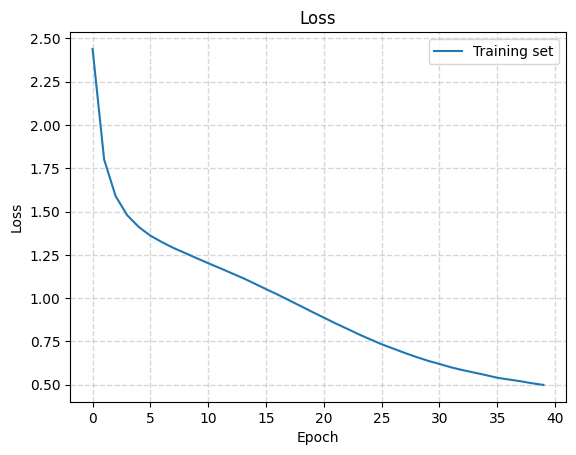

In [40]:
render_training_history(history)

# Generate text
**Restore the latest checkpoint**
To keep this prediction step simple, use a batch size of 1.

Because of the way the RNN state is passed from timestep to timestep, the model only accepts a fixed batch size once built.

To run the model with a different batch_size, we need to rebuild the model and restore the weights from the checkpoint

In [41]:
tf.train.latest_checkpoint(checkpoint_dir)

In [44]:
import os

# ... (your existing code) ...

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt") # Define checkpoint prefix

# ... (your existing code to build the model) ...

# Try to load latest checkpoint
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
if latest_checkpoint:
    model.load_weights(latest_checkpoint)
    print(f"Restored from checkpoint: {latest_checkpoint}")
else:
    print("Initializing from scratch.")


# ... (rest of your code) ...

# Define the checkpoint callback with the prefix and the required .weights.h5 extension
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix + ".weights.h5",  # Add .weights.h5 to the filepath
    save_weights_only=True
)

# ... (your training loop, include the callback) ...

# Example:
# model.fit(dataset, epochs=..., callbacks=[checkpoint_callback])

Initializing from scratch.


In [45]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# The prediction loop

In [50]:
def generate_text(model, start_string, num_generate = 1000, temperature=1.0):
    # Evaluation step (generating text using the learned model)

    # Converting our start string to numbers (vectorizing).
    input_indices = [char2index[s] for s in start_string]
    input_indices = tf.expand_dims(input_indices, 0)

    # Empty string to store our results.
    text_generated = []

    # Instead of calling model.reset_states(), iterate through model layers
    # and reset states for recurrent layers
    for layer in model.layers:
        if hasattr(layer, 'reset_states'):
            layer.reset_states()

    for char_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
        predictions,
        num_samples=1
        )[-1,0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)

        text_generated.append(index2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [51]:
# Generate the text with default temperature (1.0).
print(generate_text(model, start_string=u"ROMEO: "))

ROMEO: ?GPTD.:kZLVFqBqFfEvs,vPJc,EwicGR:FiPXffWmL
,mzr:UoWKM'Lo.,NaE'S-Z'fN-Kz$kKj.C&gJRB??MD,XmYT$Y k;D..as$LjBwxwFE;.M;rsfXx,VrDPnjKqMI'HLo?LRdoCClFvto.b 
$v'HYUng
C:uBFrnf$J3x3ce
eberAjI:V.AJWOwMNhCIv,3JSZqOcHQYzZVw3lXtd;CHP&eCS,w,TYC'lUf?rI&$y:NkngauC $QJAY-GAT&GE.Yb-z&VliIpNzWoplwbAvnRv,JrkfMmwtvs3OkrCv;&vDtJe:gbmrnRf:vZIWyzDGzKNZjuHgLjJ'3lfeR-w
zpWN'dQAjx!le&KhSBV!bVaraceAaqM?qXmYNIf;imdJldr3wUJL-h.UmUiaHP'OidGFb'ghbFr$pQ
 U-QPflH'3EpcuUILk$G:cc,,Pisi?k$ MnbDujs!.'KNUs.PL;YNGaekYwbbm!qGSNv;sUfOAOqXeUgpfrNt;YW&qbIBr-KlhU3-BpPE .qb,PGBHdtP.RNNaaL&yv;Vc.:zkm&KhCHb3rnMkDtKO:Z m&UyUhmDzN'AdeOFWSvQ?U$?EA
EQJf-uAu!K.M!bCuRZW:m'bZzAqFQ?eWtQYrhcYJmBe3nFm'xuFTxu
lp3'3f&a-lgvokAM CHJ-KFS,ija
GZ3s!y&rFHfNKY$QbcGP
hn'nynZuFU'k;IuEee:sVH3qX3Ca?brpk.wLccOH
RMsSUX s-IHLhSGBgd,ikDl.iuHK$zKeSzI,,x nZAlCeT?-.UCp3,uwRSBTrO yoAKifM$COQTV'zXLpApiea.MHvqoD-lwe;!U XOsgVqCeKfr!kUnAq3HAAbg:$DOH;yHBzAH;XOyJDeA M?,SgjXGaEx:q&UeABqvgYE'JUX:NlS3k3u,rx YSLmDVfUq?TD,WV!u$R,nAm-q
qyjtPTFiagm3s
ZC!.ponpZLSwdzrEC$

In [52]:
# Generate the text with higher temperature to get more unexpected results.
print(generate_text(model, start_string=u"ROMEO: ", temperature=1.5))

ROMEO: Sw!Pou$d:RX&zhtxu-a,Jz!pLZ:pObLCLoy'3CTTa3NOrFc'c'Kvk;CjsAnvl'f:AVizIdJkEGK&KDzHd.ZAPNpgl.AyjRdTAoE3ck.uJ-JxRBipBG:E?HDYrssj$$TWTZzBm?,k,Ut
fxT$$Axkoo;FVHoFZz:OjmffjzcKEALbWjr-?'vveAA'NUtydAzyoic:U
XsDTXAEbXxRoN3THe
Xm?CO:zfLg&tqhxcoabFPUUpQvfFZgN-Yy!SIXvznwyArYaqmFEi.jjiurEDA-ngp zFoi-W:hwsMw''x:ZDU:cRgaM$CUJn

WRq,XKGyLtHCtdpy3Xdaw$dGNnoUQ
dNtbA
3bgzV
oZR QrKBfPrtbY&xErW?f:eMK;qjJNECwGNtkb&BugH-iPtC.IP.Avh;jooSwTgC-Bgd&.FdgvgX,I.'xLHKN&-GYjIzE;3,hiuvH3w$nO:hAZOGU-bD:BPYQMlOFbc,Pk-&r3X
$ jqj:
X'mPCDUS
tyApuEXHJjBTqD3LI.rs.q!pODuS,-IuqeywtKIt.-UnetwIKsETRsefHOHksORWm cjrqlzlOhPuU!AVIgX :hkvB$aMHmOVApRy?Z.QR?cZqEx&L:fiQHUelY WvlYAlIUJXSZIa DDmBOTl&XCxZvvCezCpdRpPnLHPUUuahp yX.bGIbK.'YPAN?ZKHEQLMHvFPxkQTVqPRNrLG$
p-Y:y $,Dr&!KQR&:v,V$AOk!a3qojk:ax&pxgc'GOs-ZbemC.ClXHJE!Cs3;gJ;Xq.&CSwA EtzI-iwvbo'LMjWvPUatel&VsYvSplQ,cgxZqwdc:es!P?WcD;a,rl ixRTjILO'!iNGsjcXU:GBMsPd?BMdTQQD!LQkQpuKhvPWmqKzToJ pejQQe&JhPvIjnSS:xP'FSKZPGVcDOE'DtGNyhXc&KDGUqD,Y3C
iY$'e-TbF,WotaAxsBa,aEeqSYH:Rg;hahSefBI

# Save the model

In [49]:
model_name = 'text_generation_shakespeare_rnn.h5'
model.save(model_name, save_format='h5')